In [5]:
#Setup

!pip install mujoco

#@title Set up rendering, check installation

from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

#pls
!pip install gym
!pip install mujoco_py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 28.3 MB/s eta 0:00:00
Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.
Installing mediapy:
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.9 MB/s eta 0:00:00


In [17]:
#@title tutorial
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
  <actuator>
    <motor gear="1" joint="swing" name="swing_motor"/>
  </actuator>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.8  # (seconds)
framerate = 60  # (Hz)

frames = []
mujoco.mj_resetData(model, data)
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)

In [73]:
#@title Model and Qnetwork
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import torch.nn.functional as F

#xml for the model
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
  <actuator>
    <motor gear="1" joint="swing" name="swing_motor"/>
  </actuator>
</mujoco>
"""

#here we define the mujoco model and how our learner component interacts with it
class BoxSphereEnv(gym.Env):
    #initialize mujoco model, data which has fields on position and velocity of
    # model subcomponents, our action and observation space, and the video renderer
    def __init__(self, xml_string):
        super(BoxSphereEnv, self).__init__()
        self.model = mujoco.MjModel.from_xml_string(xml_string)
        self.data = mujoco.MjData(self.model)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(9,), dtype=np.float32)

    #given an action, apply it to observe the next state, reward,
    #and if we have finished this run or not
    def step(self, action):
        #these are where we apply selected action
        self.data.ctrl[:] = action
        mujoco.mj_step(self.model, self.data)

        #return necessary info
        observation = self._get_observation()
        reward = self._get_reward(observation)
        done = self._get_done(observation)
        return observation, reward, done, {}

    #reset the model and environment for a new run
    def reset(self):
        mujoco.mj_resetData(self.model, self.data)
        return self._get_observation()

    #get position and velocity components of our model data in our current state
    def _get_observation(self):
        observation = np.concatenate([
            self.data.qpos.flat,  # Joint positions
            self.data.qvel.flat,  # Joint velocities
            self.data.xpos.flat,  # Body positions
            self.data.xquat.flat,  # Body orientations (quaternions)
        ])
        return observation

    # This is where we set the goal of the agent. Here, its goal is to use
    # the one actuator to orient its body towards the angle 45 degrees
    # we calculate its reward as the angular difference between its current angle and 45 degrees
    def _get_reward(self, observation):
        goal_angle = -np.radians(45)
        current_angle = observation[0]
        angular_difference = np.arctan2(np.sin(current_angle - goal_angle), np.cos(current_angle - goal_angle))
        reward = np.exp(-np.abs(angular_difference))
        return reward

    #this determines how we know we've reached the end of a run (here, we define
    #the end as if it passes within bound)
    def _get_done(self, observation):
        position = observation[0]
        if position < -np.radians(40) and position > -np.radians(50):
            return True
        return False

    #render function (not implemented)
    def render(self, mode='human'):
        raise NotImplementedError

#We use the classic Qlearning algorithm. Here, we initialize the network which
#decides how much power to put into our actuator
class Qlearner(nn.Module):

    #initialize the network
    def __init__(self, state_dim, hidden_dim=64):
        super(Qlearner, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    #feedforward component
    def forward(self, state):
        x = self.relu(self.fc1(state))
        action = torch.tanh(self.fc2(x))
        return action

#setting epsilon start, end, and decay
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 50
epsilon_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * episode / epsilon_decay)

#choose our action using epsilon greedy
def select_action(state, epsilon):
    #we either explore by selecting a random action
    if np.random.rand() <= epsilon:
        return env.action_space.sample()
    #or exploit by chosing an action according to our current q
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action = q_network(state_tensor).item()
    return action

In [74]:
position = np.radians(45)
position > np.radians(40) and position < np.radians(50)

True

In [75]:
#@title Intialization
#initialize environment and qnetwork, with input a given state,
# and output the power to apply to the actuator
env = BoxSphereEnv(xml)
state_dim = 16
q_network = Qlearner(state_dim)
optimizer = optim.Adam(q_network.parameters(), lr=0.001)

In [76]:
#@title Training
total_rewards = []
avg_losses = []

num_episodes = 200
for episode in range(num_episodes):
    epsilon = epsilon_by_episode(episode)
    if episode % 10 == 0:
        print(f"Episode: {episode}, Epsilon: {epsilon:.2f}")

    state = env.reset()
    total_reward = 0
    losses = []
    done = False

    while not done:
        #select action and get next state and reward
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)

        # Compute target and loss
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
        next_q_value = q_network(next_state_tensor)

        #target q values are the expected reward for next state
        target_q_value = reward + (0.99 * next_q_value.detach().item())
        current_q_values = q_network(torch.FloatTensor(state).unsqueeze(0))

        #loss
        loss = F.mse_loss(current_q_values, torch.FloatTensor([target_q_value]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update network weights
        losses.append(loss.item())
        state = next_state
        total_reward += reward

    total_rewards.append(total_reward)
    avg_loss = np.mean(losses) if losses else 0
    avg_losses.append(avg_loss)

Episode: 0, Epsilon: 1.00


<ipython-input-76-77108dd431a1>:30: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(current_q_values, torch.FloatTensor([target_q_value]))


Episode: 10, Epsilon: 0.82
Episode: 20, Epsilon: 0.67
Episode: 30, Epsilon: 0.55
Episode: 40, Epsilon: 0.45
Episode: 50, Epsilon: 0.37
Episode: 60, Epsilon: 0.31
Episode: 70, Epsilon: 0.25
Episode: 80, Epsilon: 0.21
Episode: 90, Epsilon: 0.17
Episode: 100, Epsilon: 0.14
Episode: 110, Epsilon: 0.12
Episode: 120, Epsilon: 0.10
Episode: 130, Epsilon: 0.08
Episode: 140, Epsilon: 0.07
Episode: 150, Epsilon: 0.06
Episode: 160, Epsilon: 0.05
Episode: 170, Epsilon: 0.04
Episode: 180, Epsilon: 0.04
Episode: 190, Epsilon: 0.03


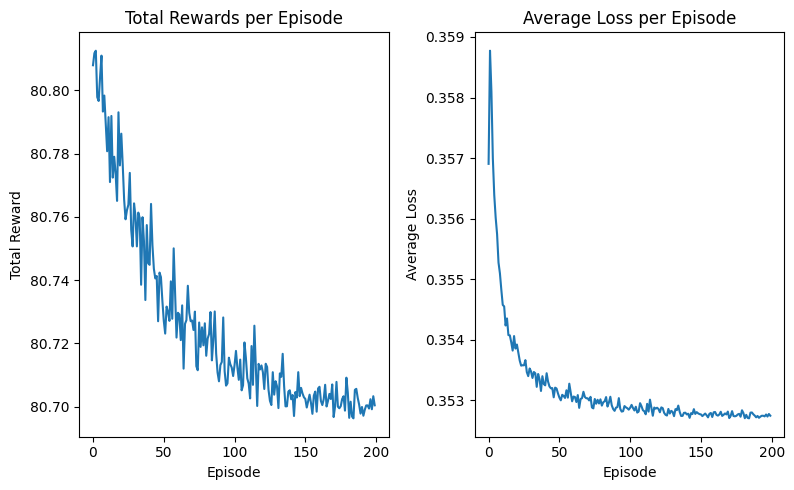

In [77]:
import matplotlib.pyplot as plt

# Plotting total rewards
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(total_rewards)
plt.title("Total Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

# Plotting average losses
plt.subplot(1, 3, 2)
plt.plot(avg_losses)
plt.title("Average Loss per Episode")
plt.xlabel("Episode")
plt.ylabel("Average Loss")

plt.tight_layout()
plt.show()

In [80]:
state = env.reset()
done = False
while not done:
        action = select_action(state, 0)
        next_state, reward, done, _ = env.step([action])
        state = next_state

print(env._get_observation()[0])

-0.7041146919010187


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
